In [243]:
!pip install webdriver_manager
!pip install selenium

In [244]:
!pip install validators

In [251]:
import pandas as pd
import torch
import os
from dotenv import load_dotenv
import openai 
import anthropic
from IPython.display import Markdown, display, update_display, Image
import google.generativeai
import base64
import datetime
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import time
import textwrap
import os
from sklearn.metrics import  accuracy_score,classification_report, confusion_matrix 
from tqdm.notebook import tqdm
import re
import validators

In [6]:
# Load environment variables in a file called .env
# Print the key prefixes to help with any debugging

load_dotenv(override=True)
openai_api_key = os.getenv('OPENAI_API_KEY')
anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')
google_api_key = os.getenv('GOOGLE_API_KEY')

if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
if anthropic_api_key:
    print(f"Anthropic API Key exists and begins {anthropic_api_key[:7]}")
else:
    print("Anthropic API Key not set")

if google_api_key:
    print(f"Google API Key exists and begins {google_api_key[:8]}")
else:
    print("Google API Key not set")

OpenAI API Key exists and begins sk-proj-
Anthropic API Key exists and begins sk-ant-
Google API Key exists and begins AIzaSyBE


In [218]:
notebook_dir = os.path.dirname(os.path.abspath("Fnd_notebook.ipynb"))
IMG_PATH=os.path.join(notebook_dir, 'public_images', 'public_image_set')

In [7]:
google.generativeai.configure()

In [8]:
train_df=pd.read_table("multimodal_train.tsv")
val_df=pd.read_table("multimodal_validate.tsv")
test_df=pd.read_table("multimodal_test_public.tsv")

In [44]:
train_df.isnull().sum()

author                   28710
clean_title                  0
created_utc                  0
domain                  167857
hasImage                     0
id                           0
image_url                 1534
linked_submission_id    396143
num_comments            167857
score                        0
subreddit                    0
title                        0
upvote_ratio            167857
2_way_label                  0
3_way_label                  0
6_way_label                  0
dtype: int64

In [148]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59319 entries, 0 to 59318
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   author                56251 non-null  object 
 1   clean_title           59319 non-null  object 
 2   created_utc           59319 non-null  float64
 3   domain                41847 non-null  object 
 4   hasImage              59319 non-null  bool   
 5   id                    59319 non-null  object 
 6   image_url             59163 non-null  object 
 7   linked_submission_id  17472 non-null  object 
 8   num_comments          41847 non-null  float64
 9   score                 59319 non-null  int64  
 10  subreddit             59319 non-null  object 
 11  title                 59319 non-null  object 
 12  upvote_ratio          41847 non-null  float64
 13  2_way_label           59319 non-null  int64  
 14  3_way_label           59319 non-null  int64  
 15  6_way_label        

In [48]:
def class_report(y_test,y_pred):
    accuracy =accuracy_score(y_test,y_pred)
    classification = classification_report(y_test,y_pred)
    print()
    print('=================== Model Evaluation =====================')
    print()
    print("Classification report:" "\n", classification)
    print()
    return accuracy

In [49]:
def conf_matrix(y_test,y_pred,acc):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10,6))
    sns.heatmap(data=cm,linewidths=.5, annot=True,square = True,  cmap = 'Blues', fmt="d")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = 'Accuracy Score: {0}'.format(acc)
    plt.title(all_sample_title, size = 25)

In [32]:
def remove_na_rows(df,col):
   return df.dropna(subset=[col])

In [35]:
def subset_df(df,cols):
   return df[cols]

In [ ]:
def encode_image(image_source):
    print(image_source)
    if image_source.startswith("http://") or image_source.startswith("https://"):
        # Handle URL
        headers = {"User-Agent": "Mozilla/5.0"}

        response = requests.get(image_source,headers=headers)
        if response.status_code == 200:
            return base64.b64encode(response.content).decode('utf-8')
        else:
            raise Exception(f"Failed to fetch image from URL: {image_source}")
    elif os.path.exists(image_source):
        # Handle local file
        with open(image_source, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')
    else:
        raise ValueError("Invalid image source. Provide a valid file path or image URL.")

In [ ]:
def google_image_search(query, num_images=5):
    # Set up Chrome with WebDriver Manager
    options = webdriver.ChromeOptions()
    options.add_argument("--headless")  # run in background
    options.add_argument("--disable-gpu")
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

    try:
        # Step 1: Go to Google Images
        driver.get("https://images.google.com/")
        time.sleep(1)

        # Step 2: Enter the search query
        search_box = driver.find_element(By.NAME, "q")
        search_box.send_keys(query)
        search_box.send_keys(Keys.RETURN)
        time.sleep(2)

        # Step 3: Extract image URLs
        image_sections = driver.find_elements(By.XPATH, '//div[@id="search"]//div[@data-attrid="images universal"]')[:num_images]
        
        all_section_images=[]
        for idx, section in enumerate(image_sections, 1):
        # Within each section, find all img tags with src
           imgs = section.find_elements(By.XPATH, './/div[2]//img[@src]')
           image_urls = [img.get_attribute("src") for img in imgs if img.get_attribute("src")]
           all_section_images.append(image_urls)

    

    finally:
        driver.quit()
    return all_section_images   



In [246]:
def is_url(s):
    return validators.url(s)

In [245]:
def get_image_filename(url):
    # Use regular expression to find the part after '.com/' and before '.jpg'
    match = re.search(r'\.com/(.*?)(?=\.[a-zA-Z]{3,4})', url)  # Match part between '.com/' and file extension
    if match:
        return match.group(1).replace('/', '_')  # Replace '/' with '_' for safe filenames
    return None  # Return None if no match is found

In [293]:
def match_image_title(df,index,id_col,title_col,scraped_imgs_url):

   # Construct the image path dynamically
   if is_url(df[id_col].iloc[index]):
       image_path_url = get_image_filename(df[id_col].iloc[index])
       image_path = os.path.join(IMG_PATH, f"{image_path_url}.jpg")
   else:    
       image_path = os.path.join(IMG_PATH, f"{df[id_col].iloc[index]}.jpg")
   encoded_image = encode_image(image_path)
   print(encoded_image)
   display(Image(encoded_image))

   result = openai.chat.completions.create(
     model="gpt-4-turbo",
     messages = [{
      "role": "user",
      "content": [
        {"type": "text", "text": f"This is title {df[title_col].iloc[index]}"},
        {"type": "text", "text": "Do you think title correctly describes the first image? If you are unsure about it check reference images and match first image with reference images.If it is a person in first image, match first image with reference images and see if they are same person.Respond with yes or no and briefly explain"},
        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encoded_image}"}},
       ] + [
        {"type": "image_url", "image_url": {"url": ref_img}}
        for ref_img in scraped_imgs_url 
      ]
   }],
    max_tokens=200
   )
   return textwrap.fill(result.choices[0].message.content, width=70)

In [294]:
def generate_query(df, title_col, date_col, index):
    date_val = df[date_col].iloc[index]
    print(date_val)
    # Check if the value is numeric (UNIX timestamp)
    if isinstance(date_val, (int, float)):
        dt = datetime.datetime.utcfromtimestamp(date_val)
    elif isinstance(date_val, str):
        try:
            dt = datetime.datetime.strptime(date_val, '%Y-%m-%d %H:%M:%S')
        except ValueError:
            return f"{df[title_col].iloc[index]}"  # Fallback if format is unexpected
    else:
        return f"{df[title_col].iloc[index]}"  # Fallback for unknown types

    year = dt.year
    return f"{df[title_col].iloc[index]} {year}"

In [292]:
# Example usage:
def predict_news_using_similarity(df,index,id_col,title_col,date_col):
   query=generate_query(df,title_col,date_col,index)
   print(query)
   images = google_image_search(f"{query}", num_images=5)
   scraped_imgs_url=[]
   for i, url in enumerate(images, 1):
     scraped_imgs_url.append(url[0])
     # print(f"Image {i}: {url[0]}")
    
   content=match_image_title(df,index,id_col,title_col,scraped_imgs_url)
    
   match = re.match(r"^(Yes|No)[,:\s-]*", content, re.IGNORECASE)
   if match:
        answer = match.group(1).lower()
        binary_label = 1 if answer == "yes" else 0
        reasoning = content[len(match.group(0)):].strip()
   else:
        binary_label = None
        reasoning = content

    # Save to the dataframe
   df.at[index, 'match_label'] = binary_label
   df.at[index, 'match_reasoning'] = reasoning
   df.at[index, 'scraped_reference_imgs']=scraped_imgs_url

In [121]:
train_df_cleaned=subset_df(remove_na_rows(train_df,'image_url'),['id','clean_title', 'created_utc', 'image_url','2_way_label'])
val_df_cleaned=subset_df(remove_na_rows(val_df,'image_url'),['id','clean_title', 'created_utc', 'image_url','2_way_label'])
test_df_cleaned=subset_df(remove_na_rows(test_df,'image_url'),['id','clean_title', 'created_utc', 'image_url','2_way_label'])

In [ ]:
id_col='id'
title_col='clean_title'
date_col='created_utc'

In [127]:
# img_title_test_pred=test_df_cleaned.copy()
# img_title_test_pred['match_label'] = None
# img_title_test_pred['match_reasoning'] = None
# img_title_test_pred['scraped_reference_imgs'] = None

In [152]:
label_counts = test_df_cleaned['2_way_label'].value_counts()
print(label_counts)

2_way_label
0    35763
1    23400
Name: count, dtype: int64


In [ ]:
# for i in tqdm(range(4, 11), desc="Processing Rows"):
#     try:
#         predict_news_using_similarity(img_title_test_pred,i,id_col,title_col,date_col)
#     except Exception as e:
#         print(f"Error processing index {i}: {e}")

In [142]:
img_title_test_pred['clean_title'][5]

'the rise of italian fascism circa'

C:\Users\pc\Documents\Journal Work Code\public_images\public_image_set\8g3xtm.jpg


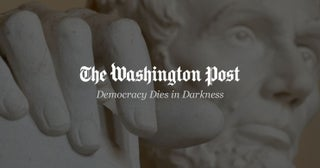

In [144]:

image_path = os.path.join(notebook_dir, 'public_images', 'public_image_set', f"{img_title_test_pred['id'].iloc[6]}.jpg")
encoded_image = encode_image(image_path)
display(Image(image_path))

In [158]:
all_data_df=pd.read_csv("all_data.csv")
all_data_df = all_data_df.loc[:, ~all_data_df.columns.str.contains('^Unnamed')]

In [186]:
all_data_df['title'][3]

'Luring Chinese Investors With Trump<U+2019>s Name, and Little Else'

In [281]:
import re
import unicodedata
from bs4 import BeautifulSoup
import string

# Map of common Unicode code points to their ASCII equivalents
unicode_replacements = {
    '2019': "'",  # right single quote
    '2018': "'",  # left single quote
    '201C': '"',  # left double quote
    '201D': '"',  # right double quote
    '2013': '-',  # en dash
    '2014': '-',  # em dash
}

def replace_unicode_placeholders(text):
    def replacer(match):
        code = match.group(1).upper()
        return unicode_replacements.get(code, '')  # Replace known codes or remove
    return re.sub(r'<U\+([0-9A-Fa-f]{4})>', replacer, text)

def clean_text(text, lowercase=True, remove_punct=True, remove_html=True):
    """
    Cleans text by removing HTML, punctuation (including apostrophes and dashes), and normalizing.
    """
    if not isinstance(text, str):
        return ''
    
    # Replace unicode placeholders
    text = replace_unicode_placeholders(text)
    
    # Remove HTML
    if remove_html:
        text = BeautifulSoup(text, "html.parser").get_text()
    
    # Normalize Unicode
    text = unicodedata.normalize("NFKD", text)
    
    # Lowercase
    if lowercase:
        text = text.lower()
    
    # Remove punctuation including apostrophes and dashes
    if remove_punct:
        text = re.sub(r"[^\w\s]", '', text)
    
    # Collapse multiple spaces and strip
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [190]:
def load_and_display_image(url, folder='allData_images'):
    filename = get_image_filename(url)
    if filename:
        image_path = os.path.join(folder, filename + '.jpg')
        if os.path.exists(image_path):
            encoded_image = encode_image(image_path)
            display(Image(image_path))
        else:
            print(f"Image not found at {image_path}")
    else:
        print("Invalid URL format.")
    return None

In [282]:
all_data_df['title'] = all_data_df['title'].fillna('').apply(clean_text)
all_data_df['text'] = all_data_df['text'].fillna('').apply(clean_text)

C:\Users\pc\AppData\Local\Temp\ipykernel_16048\2143812419.py:34: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  text = BeautifulSoup(text, "html.parser").get_text()


In [193]:
all_data_df['published'][0]

'2016-11-23 00:45:32'

allData_images\images_2016_10_18_us_18fd-trumpfoundation_18fd-trumpfoundation-master675.jpg


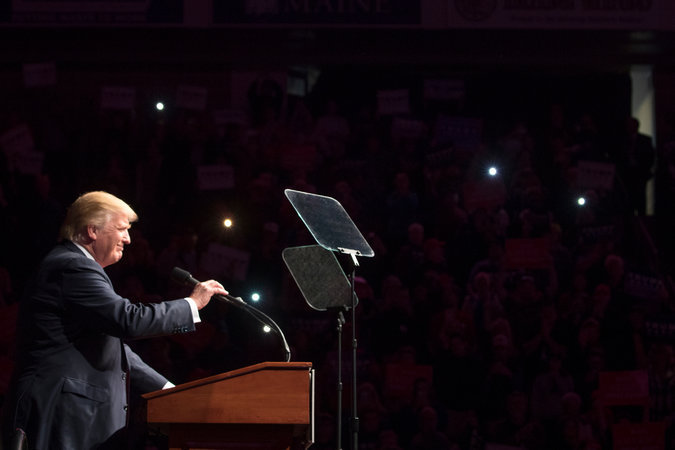

In [299]:
url = all_data_df['main_img_url'][1]
load_and_display_image(url)

In [286]:
all_data_df_cleaned=subset_df(all_data_df,['id','title', 'text', 'main_img_url','published','type'])

In [287]:
all_data_df_pred=all_data_df_cleaned.copy()
all_data_df_pred['match_label'] = None
all_data_df_pred['match_reasoning'] = None
all_data_df_pred['scraped_reference_imgs'] = None

In [288]:
id_col='main_img_url'
title_col='title'
date_col='published'

In [234]:
IMG_PATH=os.path.join(notebook_dir, 'allData_images')

In [ ]:
for i in tqdm(range(0, 1), desc="Processing Rows"):
    try:
        predict_news_using_similarity(all_data_df_pred,i,id_col,title_col,date_col)
    except Exception as e:
        print(f"Error processing index {i}: {e}")

In [296]:
all_data_df_pred.head()

,id,title,text,main_img_url,published,type,match_label,match_reasoning,scraped_reference_imgs
0,3.0,at donald trumps properties a showcase for a b...,they stood in line at trump tower sometimes up...,https://static01.nyt.com/images/2016/11/23/us/...,2016-11-23 00:45:32,real,1,"the title ""At Donald Trump's Properties, a Sho...","[data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQ..."
1,4.0,trump foundation tells new york it has stopped...,donald j trump s foundation informed attorney ...,https://static01.nyt.com/images/2016/10/18/us/...,2016-10-17 18:46:52,real,None,None,None
2,5.0,donald trump prepares for white house move but...,presidentelect donald j trump won the white ho...,https://static01.nyt.com/images/2016/11/12/us/...,2016-11-12 02:08:39,real,None,None,None
3,6.0,luring chinese investors with trumps name and ...,an investment pitch for a new texas hotel is t...,https://static01.nyt.com/images/2016/10/21/bus...,2016-10-20 22:09:04,real,None,None,None
4,7.0,melania and barron trump wont immediately move...,presidentelect donald j trump s wife melania a...,https://static01.nyt.com/images/2016/11/21/us/...,2016-11-21 01:42:23,real,None,None,None


In [297]:
all_data_df_pred["match_reasoning"][0]

'the title "At Donald Trump\'s Properties, a Showcase for a Brand\nand a President-Elect" correctly describes the first image. The image\nshows a group of people on a balcony of a building that appears to be\npart of a Trump property, as indicated by the emblem visible on the\nbalcony which is associated with Trump\'s brand. This setting aligns\nwith the description of the property being a showcase for Trump\'s\nbrand, and it captures the atmosphere during a period when he was\nPresident-Elect.'

In [290]:
all_data_df_pred["title"][0]

'at donald trumps properties a showcase for a brand and a presidentelect'